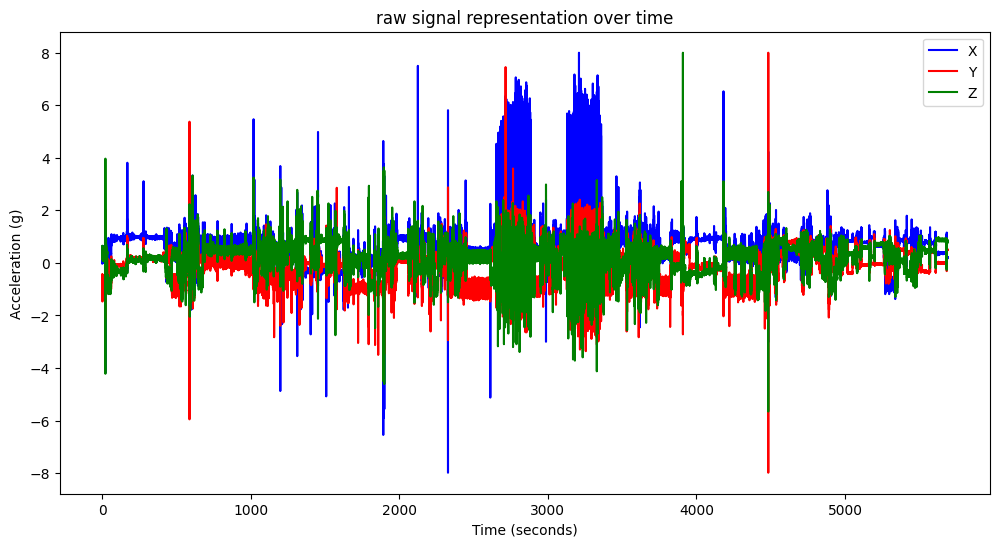

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/Users/leasaab/Documents/Dev/AX3-Project/data/SmokerCardio.csv"

data = pd.read_csv(file_path)

timestamp_column = data.columns[0]
signal_columns = data.columns[1:]   # All remaining columns are sensor data
# Inverser les colonnes de signal (X, Y, Z) directement dans 'data'
data[signal_columns] = data[signal_columns] * -1

# Convert the timestamp column to datetime
data[timestamp_column] = pd.to_datetime(data[timestamp_column], errors='coerce')  # Handle invalid dates


# Calculate the sampling interval (in seconds)
sampling_interval = (
    pd.to_datetime(data[timestamp_column].iloc[1]) -  # Access a single row
    pd.to_datetime(data[timestamp_column].iloc[0])
).total_seconds()

# Create a relative time axis (in minutes)
data['relative_time_seconds'] = data.index * sampling_interval

# Define axis labels for clarity
axis_labels = ['X', 'Y', 'Z']
colors = {'X': 'blue', 'Y': 'red', 'Z': 'green'}  # Define colors for each signal

# Plot the signal with corrected legends
plt.figure(figsize=(12, 6))
for signal, axis_label, color in zip(signal_columns, axis_labels, colors.values()):
    plt.plot(data['relative_time_seconds'], data[signal], label=axis_label, color=color)

plt.title("raw signal representation over time")
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.show()

# Low-pass filter function:

In [3]:
from scipy.signal import butter, filtfilt

# Function to apply a low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter.
    
    Parameters:
        data (array-like): The signal to filter.
        cutoff (float): The cutoff frequency in Hz.
        fs (float): The sampling frequency in Hz.
        order (int): The order of the filter (default is 4).
    
    Returns:
        array-like: The filtered signal.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

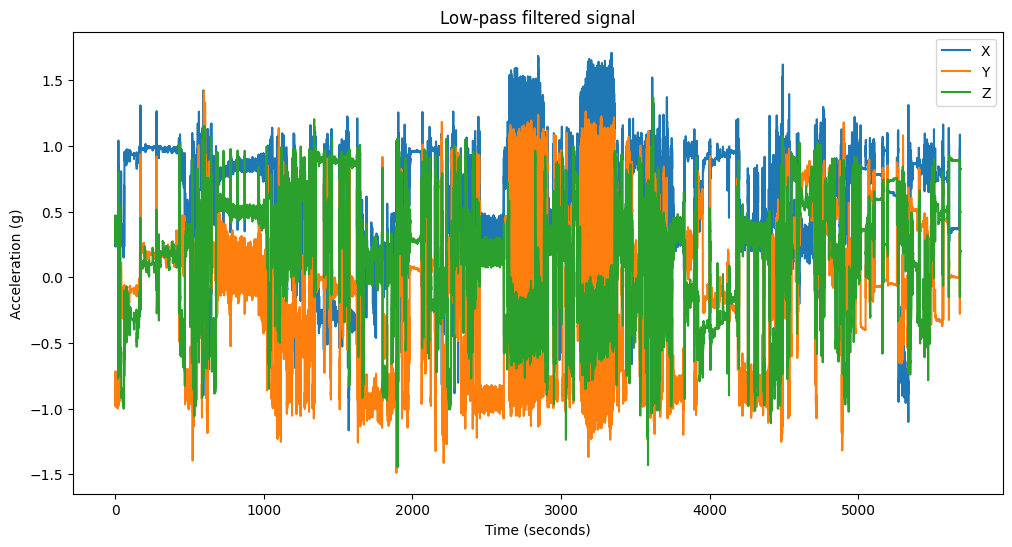

In [4]:
# Define sampling frequency (fs) and cutoff frequency
fs = 1 / (sampling_interval)  # Sampling frequency in Hz (based on time in minutes)
cutoff = 2  # Low-pass filter cutoff frequency in Hz
axis_labels = ['X', 'Y', 'Z']  # Correctly labeled for legend

# Apply the filter directly to the original filtered_data DataFrame
for signal in signal_columns:
    data[signal] = lowpass_filter(data[signal], cutoff, fs)

# Plot the low-pass filtered signals directly from filtered_data
plt.figure(figsize=(12, 6))
for signal, axis_label in zip(signal_columns, axis_labels):  # Use axis_labels for legend
    plt.plot(data['relative_time_seconds'], data[signal], label=axis_label)

plt.title("Low-pass filtered signal")
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.show()

/var/folders/qx/1f46qx2d38zfm39064m17wxm0000gn/T/ipykernel_64029/244522681.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[signal] = lowpass_filter(filtered_data[signal], cutoff, fs)


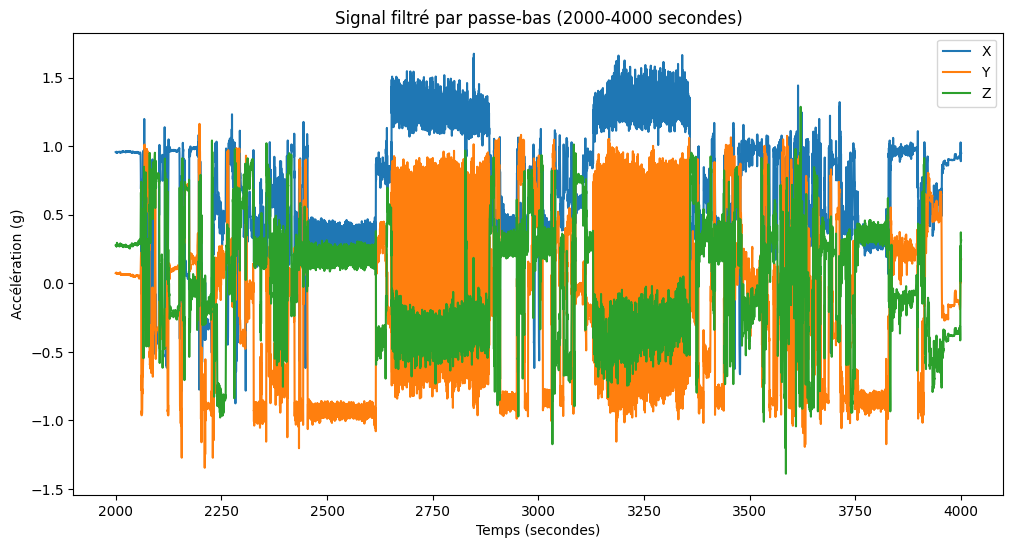

In [5]:
# Filtrer les données entre 2000 et 4000 secondes
filtered_data = data[(data['relative_time_seconds'] >= 2000) & (data['relative_time_seconds'] <= 4000)]

# Définir la fréquence d'échantillonnage (fs) et la fréquence de coupure
fs = 1 / sampling_interval  # Fréquence d'échantillonnage en Hz
cutoff = 2  # Fréquence de coupure du filtre passe-bas en Hz
axis_labels = ['X', 'Y', 'Z']  # Légendes pour les axes

# Appliquer le filtre directement aux données filtrées
for signal in signal_columns:
    filtered_data[signal] = lowpass_filter(filtered_data[signal], cutoff, fs)

# Tracer les signaux filtrés dans la plage spécifiée
plt.figure(figsize=(12, 6))
for signal, axis_label in zip(signal_columns, axis_labels):  # Utilisation des légendes pour les axes
    plt.plot(filtered_data['relative_time_seconds'], filtered_data[signal], label=axis_label)

plt.title("Signal filtré par passe-bas (2000-4000 secondes)")
plt.xlabel("Temps (secondes)")
plt.ylabel("Accélération (g)")
plt.legend()
plt.show()

# end